<a href="https://colab.research.google.com/github/fzanart/GHDomains/blob/main/Sentence_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers
!pip install flaml

     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 3.8 MB 29.0 MB/s 
     |████████████████████████████████| 1.2 MB 39.6 MB/s 
     |████████████████████████████████| 67 kB 4.9 MB/s 
     |████████████████████████████████| 895 kB 40.2 MB/s 
     |████████████████████████████████| 596 kB 48.4 MB/s 
     |████████████████████████████████| 6.5 MB 42.4 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=1b159cc73b90adeaf1ee7e0c621a7e072185325f43e9827b8bd114b4d18b3fe4
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 154 kB 12.5 MB/s 
     |████████████████████████████████| 2.0 MB 42.9 MB/s 
  At

In [ ]:
from sentence_transformers import SentenceTransformer
from flaml import AutoML
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.metrics import classification_report, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import markdown
import lxml
from bs4 import BeautifulSoup
import re
import time
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/GHDomains/expanded_frame_final.csv')
df

,Stars,Forks,Language dict,Description,Url,Readme,Topics,Languages,Licence,Labels,...,Contents,Description Length,Readme Length,Contributor Count,Topic Count,Content Count,Name,Domain,Main Language,Sum of bytes
0,323943.0,25410.0,"[{'JavaScript': 1492576, 'CSS': 103413, 'Shell...",freeCodeCamp.org's open source codebase and cu...,https://api.github.com/repos/freeCodeCamp/free...,![freeCodeCamp.org Social Banner](https://s3.a...,"['learn-to-code', 'nonprofits', 'programming',...","['JavaScript', 'CSS', 'Shell', 'HTML', 'EJS', ...","BSD 3-Clause ""New"" or ""Revised"" License","['crowdin-sync', 'first timers only', 'help wa...",...,"['.dockerignore', '.editorconfig', '.eslintign...",79.0,18148.0,410.0,15.0,40.0,freeCodeCamp/freeCodeCamp,Documentation,JavaScript,1606036
1,150012.0,71296.0,"[{'JavaScript': 738421, 'HTML': 575762, 'SCSS'...","The most popular HTML, CSS, and JavaScript fra...",https://api.github.com/repos/twbs/bootstrap,"<p align=""center"">\n <a href=""https://getboot...","['css', 'bootstrap', 'javascript', 'html', 'sc...","['JavaScript', 'HTML', 'SCSS', 'CSS', 'PowerSh...",MIT License,"['3rd-party', 'CI', 'accessibility', 'awaiting...",...,"['.babelrc.js', '.browserslistrc', '.bundlewat...",113.0,13218.0,375.0,7.0,26.0,twbs/bootstrap,Web libraries and frameworks,JavaScript,1800587
2,96800.0,22341.0,[{'JavaScript': 2361}],"Bring data to life with SVG, Canvas and HTML. ...",https://api.github.com/repos/d3/d3,"# D3: Data-Driven Documents\n\n<a href=""https:...",['visualization'],['JavaScript'],"BSD 3-Clause ""New"" or ""Revised"" License","['bug', 'code', 'docs', 'droid', 'ios', 'linux...",...,"['.gitignore', 'API.md', 'CHANGES.md', 'ISSUE_...",89.0,2305.0,122.0,1.0,13.0,d3/d3,Web libraries and frameworks,JavaScript,2361
3,168294.0,33061.0,"[{'JavaScript': 5539058, 'HTML': 115651, 'CSS'...","A declarative, efficient, and flexible JavaScr...",https://api.github.com/repos/facebook/react,# [React](https://reactjs.org/) &middot; [![Gi...,"['javascript', 'react', 'frontend', 'declarati...","['JavaScript', 'HTML', 'CSS', 'C++', 'TypeScri...",MIT License,"['Browser: IE', 'Browser: Safari', 'CLA Signed...",...,"['.circleci', '.codesandbox', '.editorconfig',...",87.0,5166.0,431.0,6.0,29.0,facebook/react,Web libraries and frameworks,JavaScript,5815290
4,59608.0,28135.0,"[{'JavaScript': 6810485, 'HTML': 84393, 'Shell...",AngularJS - HTML enhanced for web apps!,https://api.github.com/repos/angular/angular.js,AngularJS [![CircleCI](https://circleci.com/gh...,NaN,"['JavaScript', 'HTML', 'Shell', 'PHP', 'CSS']",MIT License,"['In Progress', 'Intent-To-Deprecate', 'Known ...",...,"['.circleci', '.editorconfig', '.eslintignore'...",39.0,5965.0,406.0,NaN,51.0,angular/angular.js,Web libraries and frameworks,JavaScript,6937316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1850.0,349.0,[{'Java': 32480}],This project aims to provide a working page fl...,https://api.github.com/repos/Yalantis/FlipView...,# Changes:\n\n * Made clickable views like a ...,"['android', 'java', 'viewpager', 'animation', ...",['Java'],NaN,"['bug', 'duplicate', 'enhancement', 'help want...",...,"['.gitignore', 'README.md', 'build.gradle', 'f...",86.0,4557.0,4.0,5.0,11.0,Yalantis/FlipViewPager.Draco,Non-web libraries and frameworks,Java,32480
4996,1780.0,178.0,"[{'JavaScript': 123266, 'CSS': 6537, 'HTML': 1...",JavaScript Client-Side Cookie Manipulation Lib...,https://api.github.com/repos/ScottHamper/Cookies,# Cookies.js\n\nCookies.js is a small client-s...,NaN,"['JavaScript', 'CSS', 'HTML']",The Unlicense,"['bug', 'duplicate', 'enhancement', 'invalid',...",...,"['.gitignore', 'CHANGELOG.md', 'README.md', 'U...",50.0,7338.0,11.0,NaN,7.0,ScottHamper/Cookies,Web libraries and frameworks,JavaScript,131183
4997,3138.0,300.0,"[{'C': 77760, 'Assembly': 15792}]",The earliest versions of the very first c comp...,https://api.github.com/repos/mortdeus/legacy-cc,legacy-cc\n=========\n\nThe earliest versions ...,NaN,"['C', 'Assembl

In [ ]:
pd.isna(df['Topics']).sum(), pd.isna(df['Topics']).sum()/5000

(2664, 0.5328)

In [ ]:
# Topics could be a great feature for the classifier. However, more than a half of the values are empty.
pd.concat([pd.isna(df['Topics']).groupby(by=df['Domain']).sum(),df['Domain'].value_counts(),df['Domain'].value_counts(normalize=True)], axis=1).rename({'Topics':'Missing Topics','Domain':'Total Values'},axis=1)


,Missing Topics,Total Values,Total Values
Application software,218,437,0.0874
Documentation,263,433,0.0866
Non-web libraries and frameworks,821,1439,0.2878
Software tools,462,972,0.1944
System software,83,184,0.0368
Web libraries and frameworks,817,1535,0.3070


In [ ]:
def join_words_from_lists(text, join=False):
  text = str(text)
  if text == 'nan':
    return ''
  else:
    text = text[1:-1]
    text = text.replace('\'','')
    text = text.split(',')
    if join:
      text = ' '.join([word.strip() for word in text])
    return text

In [ ]:
df['Labels'] = df['Labels'].apply(lambda x: join_words_from_lists(x, join=True))

In [ ]:
df['Labels']

0       crowdin-sync first timers only help wanted inv...
1       3rd-party CI accessibility awaiting-reply back...
2       bug code docs droid ios linux moz ms o perf pk...
3       Browser: IE Browser: Safari CLA Signed Compone...
4       In Progress Intent-To-Deprecate Known Issue Lo...
                              ...                        
4995    bug duplicate enhancement help wanted invalid ...
4996    bug duplicate enhancement invalid needs-docume...
4997    bug duplicate enhancement invalid question won...
4998                                                     
4999    breaking change bug c++11 c++14 ci compositing...
Name: Labels, Length: 5000, dtype: object

In [ ]:
def clean_htmltags(text):

    html = markdown.markdown(text)                                # convert the code to html
    soup = BeautifulSoup(html, "lxml")                            # html.parser #XML stands for "eXtensible Markup Language",
    
    [s.extract() for s in soup(['iframe', 'script'])]             # eliminate html tags 
    stripped_text = soup.get_text()                               # get the rest of the text
    stripped_text = re.sub(r'[\r|\n|\r\n]+', ' ', stripped_text)  # delete remaining tags
    text = stripped_text                                          # voila!
                                    
    return text

In [ ]:
df['Readme'] = df['Readme'].astype(str)
df['Readme'] = pd.Series([clean_htmltags(x) for x in df['Readme']]) #df['Readme'].apply(lambda x: clean_htmltags(x)) #
df['Readme'] = df['Readme'].apply(lambda x: re.sub('\s{2,}', " ", x))

In [ ]:
df['Readme']

0        freeCodeCamp.org's open-source codebase and c...
1        Bootstrap Sleek, intuitive, and powerful fron...
2       D3: Data-Driven Documents D3 (or D3.js) is a J...
3       React · React is a JavaScript library for buil...
4       AngularJS AngularJS lets you write client-side...
                              ...                        
4995    Changes: Made clickable views like a button cl...
4996    Cookies.js Cookies.js is a small client-side j...
4997    legacy-cc The earliest versions of the very fi...
4998    ELCImagePickerController A clone of the UIImag...
4999    _/ _/ _/ _/ _/_/ _/_/ _/_/_/ _/_/_/ _/_/_/ _/ ...
Name: Readme, Length: 5000, dtype: object

In [ ]:
df['Description'] = df['Description'].astype(str)
df['Description'] = df['Description'].replace('nan','')
df['Text_data']   = df['Description'] + df['Readme'] + df['Labels']

In [ ]:
df['Text_data']

0       freeCodeCamp.org's open source codebase and cu...
1       The most popular HTML, CSS, and JavaScript fra...
2       Bring data to life with SVG, Canvas and HTML. ...
3       A declarative, efficient, and flexible JavaScr...
4       AngularJS - HTML enhanced for web apps!Angular...
                              ...                        
4995    This project aims to provide a working page fl...
4996    JavaScript Client-Side Cookie Manipulation Lib...
4997    The earliest versions of the very first c comp...
4998    A clone of the UIImagePickerController using t...
4999    Mapnik is an open source toolkit for developin...
Name: Text_data, Length: 5000, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns!='Domain'], df['Domain'], test_size=0.1, random_state=42, stratify=df['Domain'])

In [ ]:
Y_train = pd.get_dummies(y_train)

def vect_reduce_features(Y_train, train, test, prefix, Selectmodel=False, Select50Best=False):

    # Save indexes
    train_text_index = train.index
    test_text_index  = test.index

    # Vectorize the words contained into lists
    vect = CountVectorizer(tokenizer=join_words_from_lists)
    train = vect.fit_transform(train.astype(str))

    # Select features to reduce the dimensionality acording the selected method (FromModel or KBest)
    Y_train = pd.get_dummies(y_train)
    labels = Y_train.columns
    selected_features = []

    if Selectmodel:

        for label in labels:
            selector =  SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False, max_iter=5000))
            selector.fit(train, Y_train[label])
            features = selector.get_support()
            selected_features.extend(list(vect.get_feature_names_out()[features]))

    if Select50Best:

        for label in labels:
            selector =  SelectKBest(chi2, k=50) # SelectFpr(chi2, alpha=0.01)
            selector.fit(train, Y_train[label])
            features = selector.get_support()
            selected_features.extend(list(vect.get_feature_names_out()[features]))

    # Apply the selected features to the vectorised train matrix
    bolean_columns = np.isin(vect.get_feature_names_out(),list(set(selected_features)))
    column_indices = [j for i in np.argwhere(bolean_columns) for j in i]
    train = train[:,bolean_columns]
    
    # Apply the selection to the test matrix
    test = vect.transform(test.astype(str))
    test = test[:,bolean_columns]

    # Transform the matrices to pd.Dataframes
    train = pd.DataFrame(train.toarray(), columns=vect.get_feature_names_out()[column_indices], index=train_text_index).add_prefix(prefix)
    test = pd.DataFrame(test.toarray(), columns=vect.get_feature_names_out()[column_indices], index=test_text_index).add_prefix(prefix)

    return train, test

In [ ]:
cn_train, cn_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'cn: ', Select50Best=True)
pl_train, pl_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'pl: ', Selectmodel=True)
tp_train, tp_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'tp: ', Selectmodel=True)
ct_train, ct_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'ct: ', Selectmodel=True)
li_train, li_test = vect_reduce_features(Y_train, X_train['Contributors'], X_test['Contributors'], 'li: ', Selectmodel=True)

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
train_vectors = model.encode(X_train['Text_data'].to_list())
test_vectors  = model.encode(X_test['Text_data'].to_list())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_vectors = pd.DataFrame(train_vectors.tolist(), index=X_train.index)
train_vectors = train_vectors.add_prefix("Text ")
test_vectors  = pd.DataFrame(test_vectors.tolist(), index=X_test.index)
test_vectors  = test_vectors.add_prefix("Text ")

In [ ]:
X_train = pd.concat([train_vectors, cn_train, pl_train, tp_train, ct_train, li_train], axis=1)
X_test  = pd.concat([test_vectors, cn_test, pl_test, tp_test, ct_test, li_test], axis=1)



In [ ]:
# X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_train_columns = X_train.columns
X_test_columns = X_test.columns

In [ ]:
automl = AutoML()
settings = {
    "time_budget": 2000,  # total running time in seconds
    "metric": 'macro_f1',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "estimator_list": ['lgbm'],
    "eval_method" : 'cv',
    "n_splits" : 10,
    "seed": 42,    # random seed
}

In [ ]:
automl.fit(X_train=X_train.to_numpy(), y_train=y_train, **settings)

[flaml.automl: 03-10 10:14:49] {2068} INFO - task = classification
[flaml.automl: 03-10 10:14:49] {2070} INFO - Data split method: stratified
[flaml.automl: 03-10 10:14:49] {2074} INFO - Evaluation method: cv
[flaml.automl: 03-10 10:14:49] {2155} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl: 03-10 10:14:49] {2248} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 03-10 10:14:49] {2501} INFO - iteration 0, current learner lgbm
[flaml.automl: 03-10 10:15:12] {2617} INFO - Estimated sufficient time budget=233068s. Estimated necessary time budget=233s.
[flaml.automl: 03-10 10:15:12] {2669} INFO -  at 23.4s,	estimator lgbm's best error=0.7358,	best estimator lgbm's best error=0.7358
[flaml.automl: 03-10 10:15:12] {2501} INFO - iteration 1, current learner lgbm
[flaml.automl: 03-10 10:15:37] {2669} INFO -  at 47.9s,	estimator lgbm's best error=0.7358,	best estimator lgbm's best error=0.7358
[flaml.automl: 03-10 10:15:37] {2501} INFO - iteration 2, current learner 

In [ ]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 394, 'num_leaves': 4, 'min_child_samples': 15, 'learning_rate': 0.2292652925479202, 'log_max_bin': 7, 'colsample_bytree': 0.9778726268416658, 'reg_alpha': 0.05466823432902029, 'reg_lambda': 0.19519145730433837}
Best accuracy on validation data: 0.5984
Training duration of best run: 43.78 s


In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test.to_numpy())
y_pred_proba = automl.predict_proba(X_test.to_numpy())[:,1]

In [ ]:
target_names, counts = np.unique(y_test, return_counts=True)
print(np.asarray((target_names, counts)).T)

[['Application software' 44]
 ['Documentation' 43]
 ['Non-web libraries and frameworks' 144]
 ['Software tools' 97]
 ['System software' 18]
 ['Web libraries and frameworks' 154]]


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

                                  precision    recall  f1-score   support

            Application software       0.43      0.30      0.35        44
                   Documentation       0.73      0.56      0.63        43
Non-web libraries and frameworks       0.72      0.75      0.74       144
                  Software tools       0.60      0.70      0.65        97
                 System software       0.60      0.33      0.43        18
    Web libraries and frameworks       0.78      0.84      0.81       154

                        accuracy                           0.70       500
                       macro avg       0.64      0.58      0.60       500
                    weighted avg       0.69      0.70      0.69       500



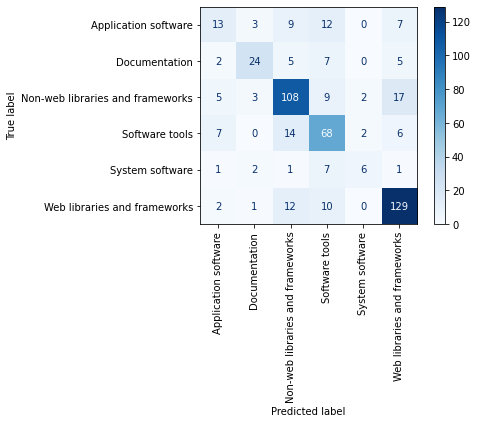

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=target_names).plot(cmap=plt.cm.Blues, xticks_rotation='vertical')